In [1]:
import warnings
warnings.filterwarnings("ignore")

import time 
import itertools

from IPython.display import clear_output

import gc
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

from typing import List
from snowballstemmer import TurkishStemmer
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java

from sklearn.svm import SVC
from sklearn import pipeline as pip
from sklearn.metrics import make_scorer
from sklearn.feature_extraction import text as txt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier 

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize.casual import casual_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, MWETokenizer, regexp_tokenize, WhitespaceTokenizer, NLTKWordTokenizer

from gensim.models import Word2Vec, word2vec, KeyedVectors
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ali.arslan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ali.arslan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ali.arslan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\ali.arslan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ali.arslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
ZEMBEREK_PATH = r'C:\Users\ali.arslan\Desktop\zemberek-tum-2.0.jar'
startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))


# Türkiye Türkçesine göre çözümlemek için gerekli sınıfı hazırla
Tr = JClass("net.zemberek.tr.yapi.TurkiyeTurkcesi")
# tr nesnesini oluştur
tr = Tr()
# Zemberek sınıfını yükle
Zemberek2 = JClass("net.zemberek.erisim.Zemberek")
# zemberek nesnesini oluştur
zemberek2 = Zemberek2(tr)

In [3]:
df_train = pd.read_csv('train_n11.csv', sep='|')
df_test = pd.read_csv('test_n11.csv', sep='|')
df_train.head()

,ID,TITLE,DESCRIPTION,CATEGORY_ID
0,46715,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık,<style>\n .uni-content {\n font-fami...,1000365
1,77151,ABC Power Sıvı Bulaşık Deterjanı 1370 G,<style>\n .uni-content {\n font-fami...,1001377
2,91464,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...,<style>\n .uni-content {\n font-fami...,1001527
3,53057,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...,"<meta name=""viewport"" content=""width=device-wi...",1000420
4,73951,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...,<style>\n .uni-content {\n font-fami...,1000958


In [4]:
def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [5]:
df_train["CATEGORY_ID"] = df_train["CATEGORY_ID"].apply(lambda x: "category_" + str(x))

df_train["cleaned_description"] = df_train["DESCRIPTION"].apply(clean_text)
df_test["cleaned_description"] = df_test["DESCRIPTION"].apply(clean_text)

df_train["cleaned_title"] = df_train["TITLE"].apply(clean_text)
df_test["cleaned_title"] = df_test["TITLE"].apply(clean_text)
    
df_train["full_text"] = df_train["cleaned_title"] + '. ' + df_train["cleaned_description"]
df_test["full_text"] = df_test["cleaned_title"] + '. ' + df_test["cleaned_description"]

In [6]:
df_train.head()

,ID,TITLE,DESCRIPTION,CATEGORY_ID,cleaned_description,cleaned_title,full_text
0,46715,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık,<style>\n .uni-content {\n font-fami...,category_1000365,Ürün Detayları Sonia SN-X60 Kulak Üstü Oyuncu ...,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık. Ürün ...
1,77151,ABC Power Sıvı Bulaşık Deterjanı 1370 G,<style>\n .uni-content {\n font-fami...,category_1001377,Ürün Detayları ABC Power Sıvı Bulaşık Deterjan...,ABC Power Sıvı Bulaşık Deterjanı 1370 G,ABC Power Sıvı Bulaşık Deterjanı 1370 G. Ürün ...
2,91464,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...,<style>\n .uni-content {\n font-fami...,category_1001527,Ürün Detayları Einhell TE-CD 18/2 Li 18V 2.5 A...,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...
3,53057,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...,"<meta name=""viewport"" content=""width=device-wi...",category_1000420,Ürün Detayları Arzum AR4095 Olimpia Smart Cycl...,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...
4,73951,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...,<style>\n .uni-content {\n font-fami...,category_1000958,Ürün Detayları Pedigree Biftekli ve Kümes Hayv...,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...


In [6]:
df_train = df_train[['cleaned_description', 'cleaned_title', 'full_text', 'CATEGORY_ID']]
df_train.head()

,cleaned_description,cleaned_title,full_text,CATEGORY_ID
0,Ürün Detayları Sonia SN-X60 Kulak Üstü Oyuncu ...,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık. Ürün ...,category_1000365
1,Ürün Detayları ABC Power Sıvı Bulaşık Deterjan...,ABC Power Sıvı Bulaşık Deterjanı 1370 G,ABC Power Sıvı Bulaşık Deterjanı 1370 G. Ürün ...,category_1001377
2,Ürün Detayları Einhell TE-CD 18/2 Li 18V 2.5 A...,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...,category_1001527
3,Ürün Detayları Arzum AR4095 Olimpia Smart Cycl...,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...,category_1000420
4,Ürün Detayları Pedigree Biftekli ve Kümes Hayv...,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...,category_1000958


In [7]:
#Create Custom Tokenizer & build pipeline

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word], lang="turkish")[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def CustomTokenizer(d):
    tokens = wordpunct_tokenize(d)
    lemmatizer = WordNetLemmatizer()
    r = []
    for token in tokens:
        pt = get_wordnet_pos(token)
        token = lemmatizer.lemmatize(token, pt)
        if len(token) >= 2:
            r.append(token)
    return r

def CustomStemmingTokenizer(d):
    tokens = wordpunct_tokenize(d)
    stemmer = TurkishStemmer()
    r = []
    for token in tokens:
        token = stemmer.stemWord(token)
        if len(token) >= 2:
            r.append(token)
    return r

def TurkishTokenizer(d):
    stopWords = set(stopwords.words('turkish'))
    tokens = wordpunct_tokenize(d)
    r = []
    for token in tokens:
        if token not in stopWords:
            if not token.isdigit():            
                result = zemberek2.kelimeCozumle(token)
                if result:
                    tok = result[0].kok().icerik()
                    new_tok = ''.join(tok)
                    if len(new_tok) >= 2:
                        r.append(new_tok)
                else:
                    tok = token.lower()
                    if len(tok) >= 2:
                        r.append(tok)
    return r



def sparsetoDense(df):
    return df.todense()


In [8]:
X_train_tknz = df_train["cleaned_title"].apply(TurkishTokenizer)
X_test_tknz = df_test["cleaned_title"].apply(TurkishTokenizer)

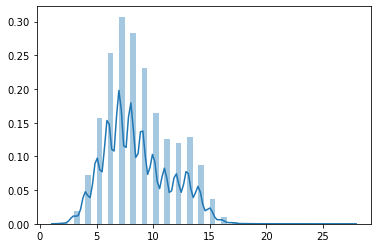

In [18]:
lengths = [len(x) for x in X_train_tknz]
sns.distplot(pd.Series(lengths));

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tknz, df_train["CATEGORY_ID"], test_size=0.25, stratify=df_train["CATEGORY_ID"], random_state=42)

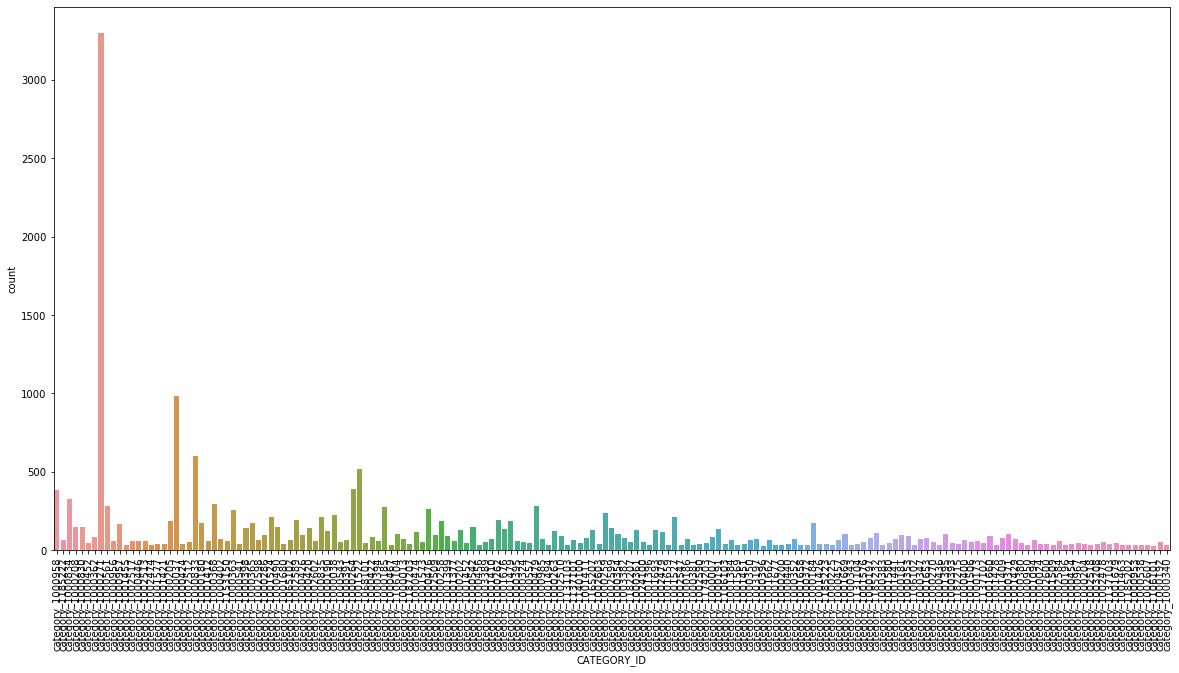

In [21]:
plt.figure(figsize=(20, 10))
sns.countplot(y_val)
plt.xticks(rotation=90);

In [10]:
def make_feature_vec(words, w2vmodel, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(w2vmodel.wv.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,w2vmodel[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(content, w2vmodel, num_features):
    """
    Calculate average feature vectors for all news
    """
    counter = 0
    review_feature_vecs = dict()
    news_feature_vecs = np.zeros((len(content),num_features), dtype='float32')  
    
    for word in content:
        review_feature_vecs[counter] = make_feature_vec(word, w2vmodel, num_features)
        counter = counter + 1
    return review_feature_vecs

**Optimization of Word2Vec**

In [27]:
# Set values for various word2vec parameters
num_features = [50, 100, 150, 200, 250]    # Word vector dimensionality                      
min_word_count = [5, 10, 15]   # Minimum word count                        
num_workers = [1]       # Number of threads to run in parallel
context = [5, 10, 15, 20]          # Context window size
downsampling = [1e-3]   # Downsample setting for frequent words

counters = []
train_acc = []
train_f1 = []
val_acc = []
val_f1 = []


params = list(itertools.product(num_workers, num_features,min_word_count, context, downsampling))
counter = 0
for param in params:
    w2vmodel = word2vec.Word2Vec(list(X_train), workers=param[0], size=param[1], min_count = param[2],
                             window = param[3], sample = param[4])
    w2vmodel.init_sims(replace=True)
    
    trainDataVecs = get_avg_feature_vecs(X_train, w2vmodel, param[1])
    valDataVecs = get_avg_feature_vecs(X_val, w2vmodel, param[1])

    trainDataVecs = pd.DataFrame.from_dict(trainDataVecs, orient='index')
    valDataVecs = pd.DataFrame.from_dict(valDataVecs, orient='index')
    
    trainDataVecs = trainDataVecs.fillna(0)
    valDataVecs = valDataVecs.fillna(0)

    nb = GaussianNB()
    
    nb.fit(trainDataVecs, y_train)
    train_pred = nb.predict(trainDataVecs)
    val_pred = nb.predict(valDataVecs)
    
    counters.append(counter)
    train_acc.append(accuracy_score(y_train, train_pred))
    train_f1.append(f1_score(y_train, train_pred, average="macro"))
    val_acc.append(accuracy_score(y_val, val_pred))
    val_f1.append(f1_score(y_val, val_pred, average="macro"))
    
    best_model_index = 0
    best_value = 0
    
    if len(val_f1) <= 1:
        best_model_index = counter
        best_value = f1_score(y_val, val_pred, average="macro")
        print("Model ",counter)
        print(param)
        print("Train Accuracy:",accuracy_score(y_train, train_pred))
        print("Train F1 Macro:",f1_score(y_train, train_pred, average="macro"))

        print("Val Accuracy:",accuracy_score(y_val, val_pred))
        print("Val F1 Macro:",f1_score(y_val, val_pred, average="macro"))
        print("="*40)
        
    elif f1_score(y_val, val_pred, average="macro") > val_f1[best_model_index]:
        best_model_index = counter        
        best_value = f1_score(y_val, val_pred, average="macro")
        clear_output(wait=True)
        print("Model ",counter)
        print(param)
        print("Train Accuracy:",accuracy_score(y_train, train_pred))
        print("Train F1 Macro:",f1_score(y_train, train_pred, average="macro"))

        print("Val Accuracy:",accuracy_score(y_val, val_pred))
        print("Val F1 Macro:",f1_score(y_val, val_pred, average="macro"))
        print("="*40)
    counter += 1  

Model  59
(1, 250, 15, 20, 0.001)
Train Accuracy: 0.9084878907395939
Train F1 Macro: 0.8612584950256962
Val Accuracy: 0.9068596293942209
Val F1 Macro: 0.8522716222890098


In [28]:
w2v_df = pd.DataFrame(
    {
     'model_id': counters,
     'train_acc': train_acc,
     'train_f1': train_f1,
     'val_acc': val_acc,
     'val_f1': val_f1
    })

w2v_df.sort_values(by='val_f1', ascending=False)

,model_id,train_acc,train_f1,val_acc,val_f1
23,23,0.909987,0.862375,0.910135,0.856192
11,11,0.910085,0.862483,0.908326,0.854287
35,35,0.908569,0.861690,0.907740,0.854227
47,47,0.908651,0.861486,0.907153,0.853612
21,21,0.907836,0.860132,0.907104,0.853123
3,3,0.908781,0.861327,0.907055,0.853032
19,19,0.907429,0.858497,0.907495,0.852542
34,34,0.908406,0.860981,0.907104,0.852483
59,59,0.908488,0.861258,0.906860,0.852272
46,46,0.907917,0.859940,0.906420,0.851925


In [29]:
params[23]

(1, 100, 15, 20, 0.001)

In [30]:
w2vmodel = word2vec.Word2Vec(list(X_train), workers=1, size=params[23][1], min_count = params[23][2],
                         window = params[23][3], sample = params[23][4])
w2vmodel.init_sims(replace=True)

trainDataVecs = get_avg_feature_vecs(X_train, w2vmodel, params[23][1])
valDataVecs = get_avg_feature_vecs(X_val, w2vmodel, params[23][1])

trainDataVecs = pd.DataFrame.from_dict(trainDataVecs, orient='index')
valDataVecs = pd.DataFrame.from_dict(valDataVecs, orient='index')

trainDataVecs = trainDataVecs.fillna(0)
valDataVecs = valDataVecs.fillna(0)

nb = GaussianNB()

nb.fit(trainDataVecs, y_train)
train_pred = nb.predict(trainDataVecs)
val_pred = nb.predict(valDataVecs)

print("Train Accuracy:",accuracy_score(y_train, train_pred))
print("Train F1 Macro:",f1_score(y_train, train_pred, average="macro"))

print("Val Accuracy:",accuracy_score(y_val, val_pred))
print("Val F1 Macro:",f1_score(y_val, val_pred, average="macro"))

Train Accuracy: 0.9099872877212426
Train F1 Macro: 0.8623749735786557
Val Accuracy: 0.9101354324548966
Val F1 Macro: 0.8561915716404302


In [44]:
#We try an LightGBM Classifier with its default parameters

lgb = LGBMClassifier(n_jobs=-1)
lgb.fit(trainDataVecs, y_train)
train_pred = lgb.predict(trainDataVecs)
val_pred = lgb.predict(valDataVecs)

print("Train Accuracy:",accuracy_score(y_train, train_pred))
print("Train F1 Macro:",f1_score(y_train, train_pred, average="macro"))

print("Val Accuracy:",accuracy_score(y_val, val_pred))
print("Val F1 Macro:",f1_score(y_val, val_pred, average="macro"))

Train Accuracy: 0.1600606277909971
Train F1 Macro: 0.07863034579199203
Val Accuracy: 0.15567398425658827
Val F1 Macro: 0.0774504432471032


Try different algorithms to compare the results and decide on which algorithm to fine tune.

In [15]:
model_list = [LGBMClassifier(n_jobs=-1, random_state=42), RandomForestClassifier(n_jobs=-1, random_state=42),
              ExtraTreesClassifier(random_state=42), SVC(random_state=42), LogisticRegression(class_weight='balanced')
             ]

train_accs = []
train_f1s = []
val_accs = []
val_f1s = []
times = []

counter = 0

for model in model_list:
    mod = model
    start_time = time.time()
    mod.fit(trainDataVecs, y_train)
    end_time = time.time()
    train_pred = mod.predict(trainDataVecs)
    val_pred = mod.predict(valDataVecs)
    
    train_accs.append(accuracy_score(y_train, train_pred))
    train_f1s.append(f1_score(y_train, train_pred, average="macro"))
    val_accs.append(accuracy_score(y_val, val_pred))
    val_f1s.append(f1_score(y_val, val_pred, average="macro"))
    times.append(end_time - start_time)
    print(counter)
    counter += 1
    

0
1
2
3
4


In [17]:
modelsdf = pd.DataFrame(
    {
     'model': model_list,
     'train_acc': train_accs,
     'train_f1': train_f1s,
     'val_acc': val_accs,
     'val_f1': val_f1s,
     'duration': times
    })

modelsdf.sort_values(by='val_f1', ascending=False)

,model,train_acc,train_f1,val_acc,val_f1,duration
2,"(ExtraTreeClassifier(random_state=1608637542),...",0.997849,0.995462,0.962402,0.931452,21.059024
1,"(DecisionTreeClassifier(max_features='auto', r...",0.997849,0.995455,0.961033,0.930892,39.528142
3,SVC(random_state=42),0.956762,0.923548,0.949934,0.909223,40.521037
4,LogisticRegression(class_weight='balanced'),0.933098,0.896720,0.929204,0.887387,54.976982
0,LGBMClassifier(random_state=42),0.077529,0.011654,0.077690,0.011530,164.564867


Fine tune the parameters of ExtraTreesClassifier

In [67]:
etc = ExtraTreesClassifier(n_jobs=-1, random_state=42)

params = {
    "n_estimators": [50, 100, 150, 200],
    "criterion": ['gini', "impurity"],
    "max_depth": [3, 5, 10, 15, 20, None],
    "min_samples_split": [2, 4, 7, 10],
    "min_samples_leaf": [1, 3, 5, 10],   
    "class_weight":["balanced", None],
}

f1_scorer = make_scorer(f1_score, average='macro')

grid1 = GridSearchCV(etc, param_grid=params, cv=3, n_jobs=-1, scoring=f1_scorer, verbose=2)
grid1.fit(trainDataVecs, y_train)

print(grid1.best_params_)

y_train_grid1 = grid1.predict(trainDataVecs)
y_val_grid1 = grid1.predict(valDataVecs)

print("Train Set Accuracy:", accuracy_score(y_train, y_train_grid1))
print("Train Set F1-Score:", f1_score(y_train, y_train_grid1, average='macro'))

print()
print("Test Set Accuracy:", accuracy_score(y_val, y_val_grid1))
print("Test Set F1-Score:", f1_score(y_val, y_val_grid1, average='macro'))

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 81.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 100.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 101.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 112.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 169.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 192.3min
[Parallel(n_jobs=-1)]: Done 4608 out of 4608 | elapsed: 193.5min finished


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Train Set Accuracy: 0.9977997979073634
Train Set F1-Score: 0.9954062119196351

Test Set Accuracy: 0.9642595218305383
Test Set F1-Score: 0.9355978288177385


In [69]:
etc = ExtraTreesClassifier(random_state=42)

#min_weight_fraction_leaf=0.0,
#min_impurity_decrease=0.0,
#min_impurity_split=None,
#ccp_alpha=0.0,
#max_samples=None --> bunu da dene

params2 = {
    "n_estimators": [200, 250, 300, 350],
    "criterion": ['gini'],
    "max_depth": [20, 25, 30],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 3,],   
    "class_weight":["balanced"],
}

f1_scorer = make_scorer(f1_score, average='macro')

grid2 = GridSearchCV(etc, param_grid=params2, cv=3, n_jobs=2, scoring=f1_scorer, verbose=2)
grid2.fit(trainDataVecs, y_train)

print(grid2.best_params_)

y_train_grid2 = grid2.predict(trainDataVecs)
y_val_grid2 = grid2.predict(valDataVecs)

print("Train Set Accuracy:", accuracy_score(y_train, y_train_grid2))
print("Train Set F1-Score:", f1_score(y_train, y_train_grid2, average='macro'))

print()
print("Test Set Accuracy:", accuracy_score(y_val, y_val_grid2))
print("Test Set F1-Score:", f1_score(y_val, y_val_grid2, average='macro'))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 13.4min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 56.6min
[Parallel(n_jobs=2)]: Done 216 out of 216 | elapsed: 77.3min finished


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 350}
Train Set Accuracy: 0.9977020111476906
Train Set F1-Score: 0.9953258634807658

Test Set Accuracy: 0.9644550921625189
Test Set F1-Score: 0.9355526895353576


In [30]:
etc2 = ExtraTreesClassifier(random_state=42,class_weight = "balanced", criterion = 'gini', max_depth = 25, 
                            min_samples_leaf= 2, min_samples_split = 4, n_estimators=350)

etc2.fit(trainDataVecs, y_train)


y_train_etc2 = etc2.predict(trainDataVecs)
y_val_etc2 = etc2.predict(valDataVecs)

print("Train Set Accuracy:", accuracy_score(y_train, y_train_etc2))
print("Train Set F1-Score:", f1_score(y_train, y_train_etc2, average='macro'))

print()
print("Test Set Accuracy:", accuracy_score(y_val, y_val_etc2))
print("Test Set F1-Score:", f1_score(y_val, y_val_etc2, average='macro'))

Train Set Accuracy: 0.9974086508686724
Train Set F1-Score: 0.995002305036637

Test Set Accuracy: 0.9651395883244511
Test Set F1-Score: 0.9369472219718431


Try another algorithm KNN to see if the distance between embedding vectors can give meaningful output 

In [12]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=10)

#Train the model using the training sets
knn.fit(trainDataVecs, y_train)

#Predict the response for test dataset
train_knn = knn.predict(trainDataVecs)
val_knn = knn.predict(valDataVecs)

In [14]:
#Predict the response for test dataset
train_knn = knn.predict(trainDataVecs)
val_knn = knn.predict(valDataVecs)

In [15]:
print("Train Set Accuracy:", accuracy_score(y_train, train_knn))
print("Train Set F1-Score:", f1_score(y_train, train_knn, average='macro'))

print()
print("Test Set Accuracy:", accuracy_score(y_val, val_knn))
print("Test Set F1-Score:", f1_score(y_val, val_knn, average='macro'))

Train Set Accuracy: 0.9539750317806969
Train Set F1-Score: 0.9213315390495824

Test Set Accuracy: 0.9430890333936341
Test Set F1-Score: 0.8983764684689628


Since the KNN outputs are promising, we tried to fine tune the parameters to achieve a better score

In [23]:
params_knn = [{'n_neighbors': np.arange(1, 30, 5), 
               'weights'    : ['uniform', 'distance'], 
               'p'          : [1, 2], # 1=Manhattan, 2=Euclidean
           } 
         ] 

knn = KNeighborsClassifier(metric='minkowski', n_jobs=-1, p=2)


f1_scorer = make_scorer(f1_score, average='macro')

grid_knn = GridSearchCV(knn, param_grid=params_knn, cv=3, n_jobs=-1, scoring=f1_scorer, verbose=1)
grid_knn.fit(trainDataVecs, y_train)

print(grid_knn.best_params_)

y_train_grid_knn = grid_knn.predict(trainDataVecs)
y_val_grid_knn = grid_knn.predict(valDataVecs)

print("Train Set Accuracy:", accuracy_score(y_train, y_train_grid_knn))
print("Train Set F1-Score:", f1_score(y_train, y_train_grid_knn, average='macro'))

print()
print("Test Set Accuracy:", accuracy_score(y_val, y_val_grid_knn))
print("Test Set F1-Score:", f1_score(y_val, y_val_grid_knn, average='macro'))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  7.9min finished


{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
Train Set Accuracy: 0.9974901398350663
Train Set F1-Score: 0.994982749493397

Test Set Accuracy: 0.960494792939911
Test Set F1-Score: 0.9278075778798393


**Voting Classifier**

We now tried to combine the algorithms we tried and achieve a higher score 

In [31]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

rfe = RandomForestClassifier(n_jobs=-1, random_state=42)

voting = VotingClassifier(estimators=[('knn', grid_knn.best_estimator_), ('etc', etc2), ('rfe', rfe)], voting='hard')

voting.fit(trainDataVecs, y_train)

train_voting = voting.predict(trainDataVecs)
val_voting = voting.predict(valDataVecs)

print("Train Set Accuracy:", accuracy_score(y_train, train_voting))
print("Train Set F1-Score:", f1_score(y_train, train_voting, average='macro'))

print()
print("Test Set Accuracy:", accuracy_score(y_val, val_voting))
print("Test Set F1-Score:", f1_score(y_val, val_voting, average='macro'))

Train Set Accuracy: 0.9978323934939209
Train Set F1-Score: 0.9954221269729705

Test Set Accuracy: 0.9652862660734367
Test Set F1-Score: 0.9375347415505414


In [32]:
rfe = RandomForestClassifier(n_jobs=-1, random_state=42)

voting2 = VotingClassifier(estimators=[('knn', grid_knn.best_estimator_), ('etc', etc2), ('rfe', rfe)], voting='soft')

voting2.fit(trainDataVecs, y_train)

train_voting = voting2.predict(trainDataVecs)
val_voting = voting2.predict(valDataVecs)

print("Train Set Accuracy:", accuracy_score(y_train, train_voting))
print("Train Set F1-Score:", f1_score(y_train, train_voting, average='macro'))

print()
print("Test Set Accuracy:", accuracy_score(y_val, val_voting))
print("Test Set F1-Score:", f1_score(y_val, val_voting, average='macro'))

Train Set Accuracy: 0.9976205221812966
Train Set F1-Score: 0.9950581171534295

Test Set Accuracy: 0.9614237520168191
Test Set F1-Score: 0.9288926972329057


**Stacking Classifier**

In [34]:
from sklearn.linear_model import LogisticRegression

rfe = RandomForestClassifier(n_jobs=-1, random_state=42)

stacking = StackingClassifier(estimators=[('knn', grid_knn.best_estimator_), ('etc', etc2), ('rfe', rfe)], final_estimator=LogisticRegression(class_weight='balanced'))

stacking.fit(trainDataVecs, y_train)

train_stack = stacking.predict(trainDataVecs)
val_stack = stacking.predict(valDataVecs)

print("Train Set Accuracy:", accuracy_score(y_train, train_stack))
print("Train Set F1-Score:", f1_score(y_train, train_stack, average='macro'))

print()
print("Test Set Accuracy:", accuracy_score(y_val, val_stack))
print("Test Set F1-Score:", f1_score(y_val, val_stack, average='macro'))

Train Set Accuracy: 0.9976531177678543
Train Set F1-Score: 0.9952792139674769

Test Set Accuracy: 0.9654818364054173
Test Set F1-Score: 0.9372880580288565


**TF-IDF**

TF-IDF vectors did not give a satisfactory results

In [139]:
pipe = pip.Pipeline([
        ("vect", txt.TfidfVectorizer(tokenizer=TurkishTokenizer, ngram_range=(1, 3), 
                                     smooth_idf=True, max_df=0.8, min_df= 0.0001)),
        ("todense", FunctionTransformer(sparsetoDense))
])

# Transform the X_train, X_trest

X_train_tfidf = pipe.fit_transform(df_train[df_train.index.isin(X_train.index)]["cleaned_title"])
X_val_tfidf = pipe.transform(df_train[df_train.index.isin(X_val.index)]["cleaned_title"])

In [140]:
#Print the tokens

len(pipe[0].get_feature_names())

17794

In [142]:
#Base Model

model = RandomForestClassifier(random_state=42, max_depth=50, n_jobs=3, verbose=1)
model.fit(X_train_tfidf, y_train)
y_train_hat = model.predict(X_train_tfidf)
y_val_hat = model.predict(X_val_tfidf)



print("Train Set Confusion Matrix:", confusion_matrix(y_train, y_train_hat), sep="\n")
print()
print("Train Set Accuracy:", accuracy_score(y_train, y_train_hat))
print()
print("Val Set Confusion Matrix:", confusion_matrix(y_val, y_val_hat), sep="\n")
print()
print("Val Set Accuracy:", accuracy_score(y_val, y_val_hat))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.7s finished


Train Set Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Train Set Accuracy: 0.16144594021969425

Val Set Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Val Set Accuracy: 0.1614433090500171


**Summary**

To sum up, so far, for the tokenization of the texts we preferred Zemberek since the language of the text is Turkish.

We tried to build a machine learning model by using Word2Vec embeddings as input. We optimized the Word2Vec algorithm by using Naive Bayes as a simple and strong algorithm in text mining.

By choosing the best parameters from the various alternatives, we determined the parameter set for our Word2Vec algorithm. Then, we started to compare algorithms with each other and find the best performing one to further optimization.

We also tried a TF-IDF vectorization, however, it did not give a promising output.
